В данной работе описана архитектура сверточных нейронных сетей VGG (от названия подразделения [Visual Geometry Group](https://www.robots.ox.ac.uk/~vgg/) в Оксфордском университете). Эта работа является одной из самых цитируемых в области компьютерного зрения, вместе с [AlexNet]($ImageNet Classification with Deep Convolutional Neural Networks$) и [ResNet]($Deep Residual Learning for Image Recognition$). Эта архитектура, благодаря своей простоте и эффективности, широко применяется до сих пор.

### Архитектура VGG

В предыдущих сверточных архитектурах применялись свертки с окном большого размера (11x11 в AlexNet, 7x7 в [ZFNet]($Visualizing and Understanding Convolutional Networks$)). Сеть VGG использует свертки 3x3, и при этом большее количество слоев.

Нормализация входных изображений осуществляется следующим образом: от каждого канала отнимается среднее значение по этому каналу, рассчитанное на всем обучающем датасете ImageNet. Деление на среднеквадратичное отклонение при этом не используется.

Сеть состоит из последовательности сверточных слоев с окном 3x3, использующих нелинейность ReLU. Входные тензоры дополняются (нулями?) по краям так, чтобы в каждом сверточном слое размер выходного тензора был равен размеру входного тензора. После некоторых сверточных слоев находятся слои max pooling с шагом 2x2 и окном 2x2. Затем авторы "вытягивают в вектор" полученную карту признаков и применяют последовательность полносвязных слоев. Выходной полносвязный слой решает задачу классификации ImageNet с 1000 классами.

Авторы тестируют несколько вариантов сети VGG с разным количеством фильтров и слоев. Количество фильтров (называемое также "шириной слоя") растет от первых к последним слоям, а пространственная размерность карт признаков уменьшается. Варианты D и E, показанные в таблице, в дальнейшем получили названия VGG-16 и VGG-19 (см., например, [документацию по VGG в PyTorch Hub](https://pytorch.org/hub/pytorch_vision_vgg/#model-description) или [код имплементации VGG в Keras](https://github.com/keras-team/keras/blob/v2.6.0/keras/applications/vgg16.py#L43-L224)).

<img src="assets/vgg.jpg" width="500" align="center">

### Почему свертки 3х3?

Авторы руководствуются следующим соображением: последовательное применение двух сверток 3x3 (без нелинейности между ними) даст рецептивное поле 5x5, применение трех подряд сверток 3x3 даст рецептивное поле 7x7, и так далее. Поэтому свертки с большим окном можно попробовать заменить последовательностью сверток 3x3. Две свертки 3x3 имеют в суме 18 весов, а свертка 5x5 иеет 25 весов, поэтому такая замена уменьшит оющее количество весов сети. Добавление нелинейностей между свертками 3x3 может дополнительно повысить выразительную способность модели.

Не любая свертка 5x5 или 7x7 может быть факторизована в последовательность сверток 3x3, но авторы не считают это проблемой и, наоборот, рассматривают как способ регуляризации сети. Например, обучение сети с двумя свертками 3x3 эквивалентно обучению сети со сверткой 5x5, но при этом сеть способна выучить только такие фильтры 5x5, которые могут быть разложены в последовательность двух фильтров 3x3.

> First, we incorporate three non-linear rectification layers instead of a single one, which makes the decision function more discriminative. Second, we decrease the number of parameters. ... This can be seen as imposing a regularisation on the 7 × 7 conv. filters, forcing them to have a decomposition through the 3 × 3 filters (with non-linearity injected in between).

Фильтры 1x1, присутствующие в некоторых вариантах VGG, добавлены для увеличения выразительной способности сети из-за наличия дополнительной нелинейности ReLU. Фильтр размера 1x1 означает применение полносвязного слоя независимо к каждому пикселю на карте признаков (к вектору, состоящему из каналов этого пикселя). Ранее фильтры 1x1 использовались в сети [Network in Network]($Network in Network$) (2013), благодаря которым эта сеть и получила свое название.

Однако авторы не вполне объясняют причину отказа от фильтров еще меньшего размера, например 3x2, 2x2 или 2x1, утверждая только следующее:

> receptive field 3×3 ... is the smallest size to capture the notion of left/right, up/down, center.

Но это не выглядит как строгое доказательство. Наверняка с такими свертками проводились эксперименты, по судя по всему они плохо проявили себя на практике. Мне неизвестны работы, где детально обосновывался бы отказ от сверток размера 2x2 и меньше.

### Проверим факторизацию фильтров экспериментом

Попробуем создать последовательность N случайных фильтров 3x3. Такую последовательность можно представить как один фильтр со стороной 3+2N. Чтобы получить ядро этого фильтра, есть как минимум два способа.

**Способ 1.** Пропустить через фильтры квадратное изображение со стороной 3+2N, состоящее из нулей , и рассчитать градиент результата по изображению.

In [14]:
import tensorflow as tf

def get_big_kernel(base_size, count):
    layers = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=1, kernel_size=base_size)
        for i in range(count)])
    w = base_size[0] + (base_size[0] - 1) * (count - 1)
    h = base_size[1] + (base_size[1] - 1) * (count - 1)
    input = tf.Variable(tf.zeros((1, w, h, 1)))
    with tf.GradientTape() as tape:
        output = layers(input)
        gradient = tape.gradient(output, input)
    return gradient.numpy()[0, :, :, 0]

**Способ 2.** Использовать последовательность слоев транспонированной свертки со случайными весами. Подать на вход один пиксель со значением 1, и на выходе получить искомое ядро фильтра со стороной 3+2N.

In [25]:
import tensorflow as tf, numpy as np

def get_big_kernel(base_size, count):
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=base_size)
      for i in range(count)
    ])
    return model(np.ones((1, 1, 1, 1))).numpy()[0, :, :, 0]

Посмотрим, как выглядят фильтры 9x9, факторизуемые в последовательность фильтров 3x3:

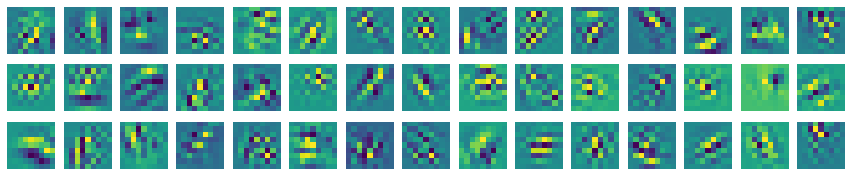

In [38]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=15, figsize=(15, 3))
for ax in axes.flat:
    ax.imshow(get_big_kernel(base_size=(3, 3), count=4))
    ax.axis('off')

Как видим, даже со случайной инициализацией весов фильтров 3x3, полученные фильтры 9x9 не выглядят как случайно инициализированные. Теперь проведем такой же эксперимент, факторизуя фильтр 9x9 в фильтры 2x2:

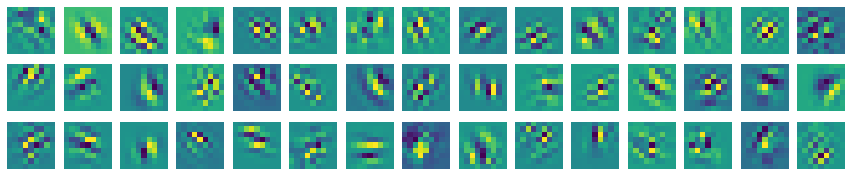

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=15, figsize=(15, 3))
for ax in axes.flat:
    ax.imshow(get_big_kernel(base_size=(2, 2), count=8))
    ax.axis('off')

Теперь создадим фильтр 9x9, факторизуемый в фильтры 3x1 и 1x3:

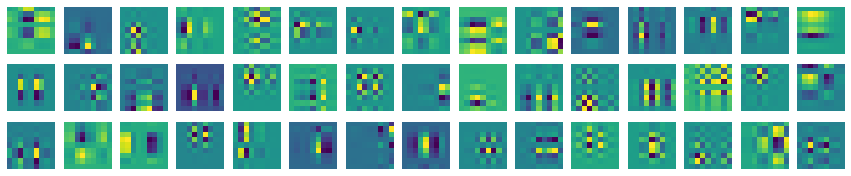

In [36]:
def get_big_kernel_interleave(base_size, count):
    model = tf.keras.Sequential([
        tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=base_size),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=base_size[::-1])
        ])
        for i in range(count)
    ])
    return model(np.ones((1, 1, 1, 1))).numpy()[0, :, :, 0]

fig, axes = plt.subplots(nrows=3, ncols=15, figsize=(15, 3))
for ax in axes.flat:
    ax.imshow(get_big_kernel_interleave(base_size=(3, 1), count=4))
    ax.axis('off')

Создадим фильтры 9x9, факторизуемые в фильтры минимально возможного размера: 2x1 и 1x2:

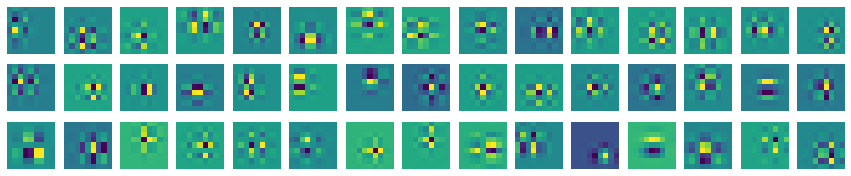

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=15, figsize=(15, 3))
for ax in axes.flat:
    ax.imshow(get_big_kernel_interleave(base_size=(2, 1), count=8))
    ax.axis('off')

Как видим, фильтры, факторизуемые с помощью чередования 1xN и Nx1 имеют свою специфику. Судя по всему, они не способны, например, выделять диагональные линии. Однако суперпозиция фильтров 2x2 дает такую же картину, что и суперпозиция фильтров 3x3.

Исходя из этого, отказ от фильтров размера 2x2 все еще непонятен. 